## Common Class

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math

from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator

In [10]:
class Common_Class():

    def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):        
        #new dicts as now there will be multiple stocks. Each stock will have its own position/quantity etc
        self.all_data ={}
        self.position = {}
        self.quantity = {}
        for stock in symbol:
            self.quantity['{}'.format(stock)] = 0 #can also do at run strategy, but its different design
        self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details

        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital # this is the initial capital you want to trade with
        self.capital = capital # this capital will change depending on trades
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.trades = 0 # Number of trades
        self.verbose = verbose # if you want to see detailed output (logs)
        self.prepare_data() # prepares the data
        
    def prepare_data(self):
        # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
        # we will calculate the returns though.
        # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.
        # Get the data for all the tickers
        for ticker in self.symbol:
            hist_stock = pdr.get_data_yahoo(ticker, start = self.start, end = self.end,)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_stock["Adj Close"]
            bt_data["Open_Price"] = hist_stock["Open"]
            bt_data["Low_Price"] = hist_stock["Low"]
            bt_data["High_Price"] = hist_stock["High"]
            bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()
            self.all_data[ticker] = bt_data

        # Get the data for the benchmark
        hist_benchmark = pdr.get_data_yahoo("^GSPC", start = self.start, end = self.end,)
        bt_data = pd.DataFrame()
        bt_data["Close_Price"] = hist_benchmark["Adj Close"]
        bt_data["Benchmark Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
        bt_data = bt_data.dropna()
        self.benchmark_df = bt_data
    
    def close_graph(self, ticker):
        plt.figure(figsize=(15, 5))
        plt.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(ticker))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, bar, stock): #now we will also pass the stock as parameter
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        i = str(stock)
        date = str(self.all_data[i].index[bar])[:10]  # :10 to only get the date
        price = self.all_data[i].Close_Price.iloc[bar]
        return date, price

    def realised_balance(self, bar):
        #returns the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
        print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

    def unrealised_balance(self, bar):
        #returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

    def total_balance(self, bar):
        #Unrealised plus realised
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        tb = ub + self.capital
        #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
        return tb

    def store_results(self, trade, date, position, price, symbol, quantity, capital):
        trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
        self.stored_data = pd.concat([self.stored_data, trade_detail])

    def performance_plots(self):# once we have dataframe of daily account balances
        Final_result_data = self.Final_result_data #saving time to write self everywhere
        interval = str(self.interval)
        f,ax = plt.subplots(2,3,figsize=(20,10))

        #plot 1: Close Price os stock
        plt.subplot(2, 3, 1)
        for stock in self.symbol:
            plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
        plt.title("Cum Log returns of included stocks")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 2: Histogram of dtrstegy returns
        plt.subplot(2, 3, 2)
        plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
        plt.title("Histogram of Strategy returns")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 3: Strategy vs Instrument
        plt.subplot(2, 3, 3)
        plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
        plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
        plt.title("Strategy Vs Stock Cum Return Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 4: Drawdown
        plt.subplot(2, 3, 4)
        plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
        plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
        plt.title("Drawdown")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 5: Equity Curve
        plt.subplot(2, 3,  5)
        plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
        plt.title("Equity Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        plt.suptitle("Performance Plots")
        f.delaxes(ax[1,2]) # to delete the last subplot

        plt.show()

    def performance(self):
        # stored data has  [trade, date, position, price, symbol, quantity, capital]
        #B = self.stored_data # this will have many rows ; n(number of instruments) times more
        #C = self.all_data # will need this to aggregate the returns from all stocks
        #B.index = range(B.shape[0]/len(self.symbol))

        #Since the stocks are not stored in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
        #stored data has many rows, we will aggregate day wise

        df = pd.DataFrame() # creating a new datframe to store aggregated values

        df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
        #df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

        trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time, for daily, its fine
        trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

        #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

        # fill in the capital for the days that we are not trading
        capital = self.initial_capital
        for date in self.all_data[self.symbol[0]][trade_start_date:trade_end_date].index:
            if date.strftime('%Y-%m-%d') not in df.index:
                df.loc[date.strftime('%Y-%m-%d'),"capital"] = capital
            else:
                capital = df.loc[date.strftime('%Y-%m-%d'),"capital"]
        self.capital_per_day = df
        for stock in self.symbol:
            A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # The returns are already log
            df['Returns_{}'.format(stock)] = A
        c= df.columns #fetch all the columns of datframe
        df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
        df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
        df.index = range(df.shape[0])

        df['capital_after_settlement'] = df['capital'].shift(-1)

        # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
        #Remember, you can change the returns on investment based on the capital you trade

        df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
        df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
        df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

        # for drawdown calculation
        df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
        df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
        # The maximum difference is refered as "Drawdown"

        df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
        df = df.dropna()
        #print(df.head())

        '''
        #arranging the columns for better readeability
        cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price',\
                     'price_log_returns','price_log_returns_cum_sum','capital',\
                    'capital_after_settlement', 'capital_regular_returns', 'capital_log_returns',\
                     'capital_returns_log_cum_sum','Cum_Max','drawdown']
        B = B[cols]
        B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

        '''

        #storing the results in Final_result data
        Final_result_data = df
        #Final_result_data.head()

        #Plot the equity curve
        #plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
        #Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

        print("=" *50)
        print("Performance Metrics")

        #Total Balance
        print("The total capital at end of strategy: {:0.1f}".format(self.capital))

        # Annual gross expected returns
        daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
        annual_log_ret = 252 * daily_log_mean_ret
        annual_regular_return = (np.exp(annual_log_ret) -1)*100
        print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

        # Annual std deviation
        daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
        annual_regular_std =  daily_regular_std * (252 **0.5) *100
        print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

        #Annual Sharpe Ratio
        SR = annual_regular_return / annual_regular_std
        print("The annual Sharpe Ratio: {:0.2f}".format(SR))

        #The strategy returns on investment in percent

        #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
        #Total_Log_ret
        #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
        #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

        # the above method will also produce same result

        returns = (self.capital - self.initial_capital) /self.initial_capital *100
        print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

        #Calculate Drawdown
        #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")

        Drawdown = Final_result_data["drawdown"].max()*100
        print("The maximum drawdown: {:.2f} %".format(Drawdown))

        zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
        delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
        print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

        #Annual Sortino Ratio
        only_neg_log_returns = Final_result_data[Final_result_data['capital_log_returns']<0]['capital_log_returns']
        only_neg_regular_returns = np.exp(only_neg_log_returns)-1

        daily_std_dev_for_sortino = only_neg_regular_returns.std()
        annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

        sortino = annual_regular_return / annual_std_dev_for_sortino
        print("The annual Sortino Ratio: {:0.2f}".format(sortino))

        #Total trades
        print("The total trades taken by the strategy: {}".format(self.trades))


        print("=" *50)

        self.Final_result_data = Final_result_data
        #print(self.Final_result_data.head())


    def buy_order(self,bar,stock,quantity=None, dollar =None ):
        date, price = self.return_date_price(bar,stock)
        if quantity == None:
            quantity = int(dollar/price)
        self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = 1
        tb = self.total_balance(bar)
        #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


        if self.verbose:
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            #self.unrealised_balance(bar)
            #self.total_balance(bar)


    def sell_order(self,bar,stock, quantity=None, dollar=None ):
        date, price = self.return_date_price(bar, stock)
        if quantity == None:
            quantity = int(dollar/price)
        self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = -1
        tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


        if self.verbose:
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            #self.unrealised_balance(bar)
            #self.total_balance(bar)

    def last_trade(self, bar):# thi sneeds to be check for all open positions of all stocks

        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            last_quantity = self.quantity['{}'.format(stock)]
            self.capital = self.capital + last_quantity * price
            self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
            self.trades = self.trades +1
            if self.position['{}'.format(stock)] == -1: # if closing out a short position
                last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
                self.position['{}'.format(stock)] = 1 # to record we are buying to close out
            else:
                last_quantity =  last_quantity # to keep a positve nymber in records
                self.position['{}'.format(stock)] = -1 # to record we are selling to close out
            #self.position = 0
            tb = self.total_balance(bar)
            self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

            if self.verbose:
                print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))

## Trading Strategy Logic

In [35]:
class MA_Strategy(Common_Class):
    
    def __init__(self,symbol, benchmark,start, end, interval, capital, transcation_cost, primary_trend_window,buy_on,long_sl_ATR_multiple,risk_reward_long,
                 close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,
                 close_n_sma_distance_short_multiple,short_rsi_limit,verbose):
        super().__init__(symbol, start, end, interval, capital, transcation_cost,verbose)
        self.primary_trend_window = primary_trend_window
        self.buy_on= buy_on
        self.long_sl_ATR_multiple = long_sl_ATR_multiple,
        self.risk_reward_long = risk_reward_long,
        self.close_n_sma_distance_long_multiple= close_n_sma_distance_long_multiple,
        self.long_rsi_limit = long_rsi_limit,
        self.short_sl_ATR_multiple = short_sl_ATR_multiple,
        self.risk_reward_short = risk_reward_short,
        self.close_n_sma_distance_short_multiple = close_n_sma_distance_short_multiple,
        self.short_rsi_limit = short_rsi_limit
        self.portfolio_df = pd.DataFrame()

    def close_position(self, ticker, bar):
        if self.position[ticker] == 1:
            self.sell_order(bar,ticker, quantity = self.quantity[ticker]) # to clear previous long position
            
        if self.position[ticker] == -1:
            self.buy_order(bar,ticker, quantity = -self.quantity[ticker]) #to clear previous short position and therefore negative quantity.
            
        self.position[ticker] = 0
    
    def go_long(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.buy_order (bar,ticker, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.buy_order(bar,ticker, dollar = dollar)
        
    def go_short(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.sell_order(bar,ticker, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.sell_order(bar,ticker, dollar = dollar)


    def visualise_strategy(self, ticker, STMA_window, LTMA_window, axs):
            axs.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
            axs.plot(self.all_data[ticker]["SMA"], color='b', label='Short term MA')
            # axs.plot(self.all_data[ticker]["LTMA"], color='r', label='Long term MA')
            open_long_bool = self.all_data[ticker]['Open_Entry'] == "Open Long"
            open_short_bool = self.all_data[ticker]['Open_Entry'] == "Open Short"
            close_long_bool = (self.all_data[ticker]['Close_Entry'] == "Close Long at TP") | (self.all_data[ticker]['Close_Entry'] == "Close Long at SL")
            close_short_bool = (self.all_data[ticker]['Close_Entry'] == "Close Short at TP") | (self.all_data[ticker]['Close_Entry'] == "Close Short at SL")
            axs.plot(self.all_data[ticker][open_long_bool|open_short_bool].index,
                        self.all_data[ticker][open_long_bool|open_short_bool]['SMA'],
                        '^', markersize = 15, color = 'g', label = 'buy/long')
            axs.plot(self.all_data[ticker][close_long_bool|close_short_bool].index,
                        self.all_data[ticker][close_long_bool|close_short_bool]['SMA'],
                        'v', markersize = 15, color = 'r', label = 'sell/short')

            axs.set_xlabel("Days")
            axs.set_ylabel("Price")
            axs.set_title("Moving Averages Crossover {} Vs {} for {}".format(STMA_window, LTMA_window, ticker))
            axs.legend()
            plt.grid()

    def visualise_position(self, ticker, axs):
            axs.plot(self.all_data[ticker]["Final Position"])
            axs.set_title("Long/Short status for {}".format(ticker))
            axs.grid()

    def visualise_stock_returns_distribution(self, ticker, axs):
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Strategy_Returns"] != 0]["Strategy_Returns"], bins = 40, label='Strategy Returns', alpha=0.5)
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Stock_Returns"] != 0]["Stock_Returns"], bins = 40, label='Stock Returns', alpha=0.5)
            axs.set_title("Histogram of Stock Daily Log Returns for {}".format(ticker))
            axs.legend()
            axs.grid()

    def visualise_stock_and_strategy_returns(self, ticker, axs):
            axs.plot(self.all_data[ticker][["Strategy_Returns"]].cumsum(), label='Strategy_Returns')
            axs.plot(self.all_data[ticker][["Stock_Returns"]].cumsum(), label='Stock_Returns')
            axs.legend()
            axs.set_title('Stock vs Strategy Returns for {}'.format(ticker))
            axs.grid()

    def run_strategy(self, STMA_window, LTMA_window):
            self.strengths_df = pd.DataFrame(columns=self.symbol)
            
            for ticker in self.all_data.keys():
                # Get indicators for all the tickers
                SMA = SMAIndicator(close = self.all_data[ticker]["Close_Price"], window = self.primary_trend_window, fillna= False)
                ATR = AverageTrueRange(high = self.all_data[ticker]["High_Price"],
                                   low = self.all_data[ticker]["Low_Price"],
                                   close = self.all_data[ticker]["Close_Price"])
                RSI = RSIIndicator(close =  self.all_data[ticker]["Close_Price"])
                MACD_ = MACD(close = self.all_data[ticker]["Close_Price"]) 
                self.all_data[ticker]["SMA"] = SMA.sma_indicator()

                self.all_data[ticker]['ATR'] = ATR.average_true_range()
                self.all_data[ticker]['MACD Fast'] = MACD_.macd()
                self.all_data[ticker]['MACD Slow'] = MACD_.macd_signal()
                self.all_data[ticker]['RSI'] = RSI.rsi()

                self.all_data[ticker]['Stop Loss Long'] = self.all_data[ticker]["Open_Price"] - self.long_sl_ATR_multiple*self.all_data[ticker]['ATR'] # 2
                self.all_data[ticker]['Take Profit Long'] = self.all_data[ticker]["Open_Price"] +self.risk_reward_long*(self.long_sl_ATR_multiple*self.all_data[ticker]['ATR']) # 1

                self.all_data[ticker]['Stop Loss Short'] = self.all_data[ticker]["Open_Price"] + self.short_sl_ATR_multiple*self.all_data[ticker]['ATR'] # 1
                self.all_data[ticker]['Take Profit Short'] = self.all_data[ticker]["Open_Price"]-self.risk_reward_short*(self.short_sl_ATR_multiple*self.all_data[ticker]['ATR']) # 0.5
                
                
                ## Signal Logic
                self.all_data[ticker]['signal_1'] = np.where( 
                                    (self.all_data[ticker]['Close_Price'] > (self.all_data[ticker]['SMA'] - self.close_n_sma_distance_short_multiple*self.all_data[ticker]['ATR']) ) & (self.all_data[ticker]['Close_Price'] < self.all_data[ticker]['SMA']),
                                    -1.0,   0) # When it is between the close and abit below it, we short, 0,5

                self.all_data[ticker]['signal_1'] = np.where( 
                                    (self.all_data[ticker]['Close_Price'] < (self.all_data[ticker]['SMA'] + self.close_n_sma_distance_long_multiple*self.all_data[ticker]['ATR']) ) & (self.all_data[ticker]['Close_Price'] > self.all_data[ticker]['SMA']) ,
                                    1.0,  self.all_data[ticker]['signal_1']) # When it is between the close and abit above it, we long, 2

                self.all_data[ticker]['signal_2'] = np.where(self.all_data[ticker]['MACD Fast'] >  self.all_data[ticker]['MACD Slow'],1.0,-1.0)
                self.all_data[ticker]['Signal Combined'] = ( self.all_data[ticker]['signal_1']+ self.all_data[ticker]['signal_2'] )/2.0
                self.all_data[ticker]['Signal Clean'] = self.all_data[ticker]['Signal Combined'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
                self.all_data[ticker]['Strength of Signal'] = ((abs(self.all_data[ticker]['Close_Price'] - self.all_data[ticker]['SMA'])/self.all_data[ticker]['Close_Price'] + abs(self.all_data[ticker]['MACD Fast'] -  self.all_data[ticker]['MACD Slow']))) * self.all_data[ticker]['Signal Clean']
                self.strengths_df[ticker] = self.all_data[ticker]['Strength of Signal']
                self.all_data[ticker]['Final Position'] = 0
            
            # Stock with the strongest Signal
            self.strengths_df['Chosen'] = self.strengths_df.abs().idxmax(axis=1)
            self.strengths_df['Chosen'] = np.where (self.strengths_df[self.symbol].abs().max(axis = 1) == 0.0, "", self.strengths_df['Chosen'])
            self.strengths_df['Chosen'] = self.strengths_df['Chosen'].shift(1)
            latest_action,stock_bought = 0,""
            for bar in range(self.primary_trend_window, len(self.all_data[self.symbol[0]])):
                date, _ = self.return_date_price(bar, ticker)
                chosen_stock = self.strengths_df.loc[date,"Chosen"]
                if (stock_bought):
                    # if we are already in a long 
                    curr_open_price = self.all_data[stock_bought]["Open_Price"].iloc[bar]
                    if (self.position[stock_bought] == 1): 
                        # Close Long if it hits TP
                        if (curr_open_price  >=  curr_TP ) | (self.all_data[stock_bought]["RSI"].iloc[bar]>self.long_rsi_limit): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at TP"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            print("Close Long at TP")

                        # Close Long if it hits SL
                        elif (curr_open_price <= curr_stop ): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at SL"
                            print("Close Long at SL")
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""

                    # if we are already in a short
                    elif (self.position[stock_bought] == -1):
                    # Close Short if it hits SL
                        if (curr_open_price  >= curr_stop ) | (self.all_data[stock_bought]["RSI"].iloc[bar]<self.short_rsi_limit): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at SL"
                            print(f"Close Short at SL curr price is {curr_open_price} and stop loss is at {curr_stop}")
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""

                    # Close SHort if it hits TP
                        elif (curr_open_price  <= curr_TP ): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at TP"
                            print("Close Short at TP")
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                    
                if (latest_action == 0) & (chosen_stock != ""): # if we are not in any position
                    if self.all_data[chosen_stock]["Signal Clean"].iloc[bar-1] == 1:
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Long"].iloc[bar-1],self.all_data[chosen_stock]["Take Profit Long"].iloc[bar-1]
                        self.go_long(chosen_stock, bar, dollar="all") # go with all money
                        self.position[chosen_stock] = 1 # long created
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Long"
                        latest_action,stock_bought = 1,chosen_stock
                        print("-------------------")
                    
                    elif self.all_data[chosen_stock]["Signal Clean"].iloc[bar-1] == -1:
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Short"].iloc[bar-1],self.all_data[chosen_stock]["Take Profit Short"].iloc[bar-1]
                        self.go_short(chosen_stock, bar, dollar ="all") # go with all money
                        self.position[chosen_stock] = -1 # short created
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Short"
                        latest_action,stock_bought = -1,chosen_stock
                        print("---------------------")
                
                if (latest_action!=0) & (stock_bought!= ""): 
                    self.all_data[stock_bought].loc[date,'Final Position'] = latest_action
                    self.portfolio_df.loc[date,"Strategy Returns 2"] = self.all_data[stock_bought].loc[date,'Return']
                
                self.portfolio_df.loc[date,"Chosen"] = stock_bought
                # Get the daily portfolio total balance, unrealised balance and realised balance
                # self.daily_portfolio_information(bar)

            # Last trade
            self.last_trade(bar)

            print("-----------------------------------")
            print("---------- Portfolio statistics ----------")
            self.performance()

#             # Visualise portfolio performance
            self.performance_plots()

            # Visualisation strategy for each ticker
            for ticker in self.all_data.keys():
                # Add position and signal column to the data
                self.all_data[ticker]['Signal'] = self.all_data[ticker]['Final Position'].diff()
                # Add stock returns
                self.all_data[ticker]['Stock_Returns'] = np.log(self.all_data[ticker]["Close_Price"] / self.all_data[ticker]["Close_Price"].shift(1))
                # Add strategy returns
                self.all_data[ticker]["Strategy_Returns"] = self.all_data[ticker]["Stock_Returns"] * self.all_data[ticker]["Final Position"].shift(1)

                # Visualtions
                fig, ax = plt.subplots(2, 2, figsize=(15, 8))
                self.visualise_strategy(ticker, STMA_window, LTMA_window, axs=ax[0][0])
                self.visualise_position(ticker, axs=ax[0][1])
                self.visualise_stock_and_strategy_returns(ticker, axs=ax[1][0])
                self.visualise_stock_returns_distribution(ticker, axs=ax[1][1])
                fig.tight_layout()
                plt.show()


In [36]:
# configurations
tickers = ["AAPL", "GOOG", "NFLX", "AMZN","META"] # META excluded because META IPO on 2012, data setsize is different
total_capital = 40000

primary_trend_window = 50 # 50 
lookback = 652
buy_on = "Open"
verbose = False

# Long Parameters
long_sl_ATR_multiple = 2 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 2.5 # Used to determine how close to SMA can be bought
long_rsi_limit = 80

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 1   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5 # Used to determine how close to SMA can be bought
short_rsi_limit = 20

benchmark_stock_symbol = "^GSPC"

start = "2015-01-01"
end = "2019-12-31"

Sold 669 shares of NFLX at 59.8 per share worth 39998.6 $
Total quantity for NFLX is -669
Date :2015-03-17 | Realised Balance: 79598.6
---------------------
Bought 669 shares of NFLX at 60.4 per share worth 40438.2 $
Total quantity for NFLX is 0
Date :2015-03-18 | Realised Balance: 38756.0
Close Short at TP
Sold 638 shares of NFLX at 60.7 per share worth 38754.9 $
Total quantity for NFLX is -638
Date :2015-03-19 | Realised Balance: 77123.3
---------------------
Bought 638 shares of NFLX at 60.2 per share worth 38439.5 $
Total quantity for NFLX is 0
Date :2015-03-25 | Realised Balance: 38299.4
Close Short at SL curr price is 62.68428421020508 and stop loss is at 61.38234724074411
Bought 468 shares of META at 81.7 per share worth 38221.6 $
Total quantity for META is 468
Date :2015-04-01 | Realised Balance: -304.4
-------------------
Sold 468 shares of META at 79.0 per share worth 36967.3 $
Total quantity for META is 0
Date :2015-05-01 | Realised Balance: 36293.3
Bought 0 shares of META a

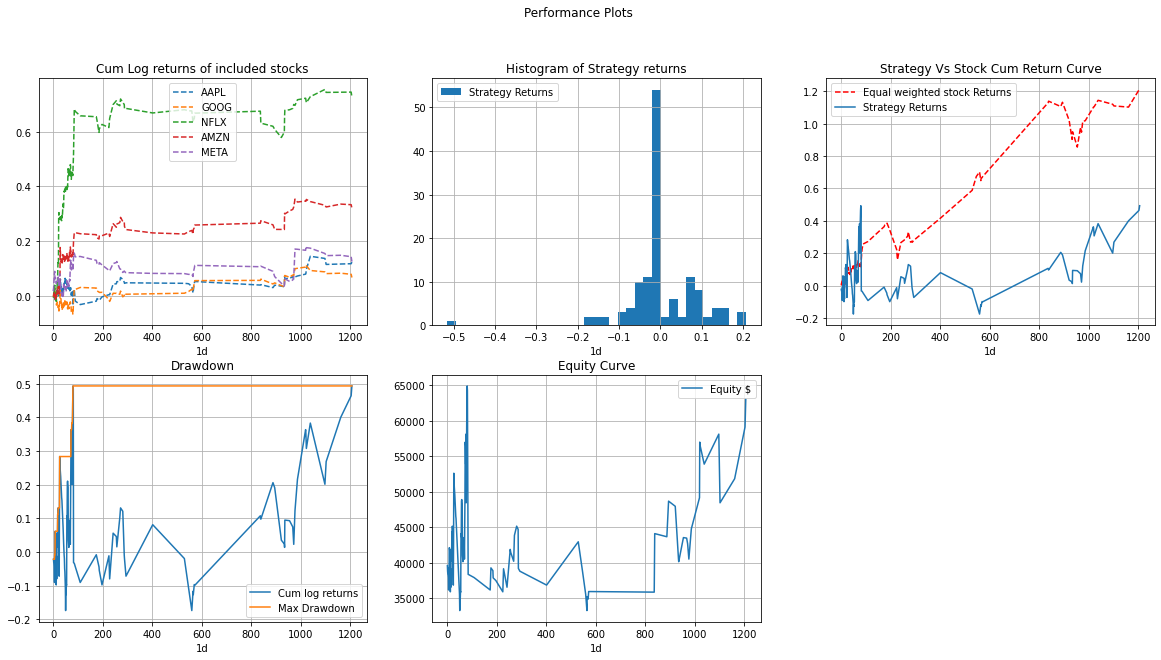

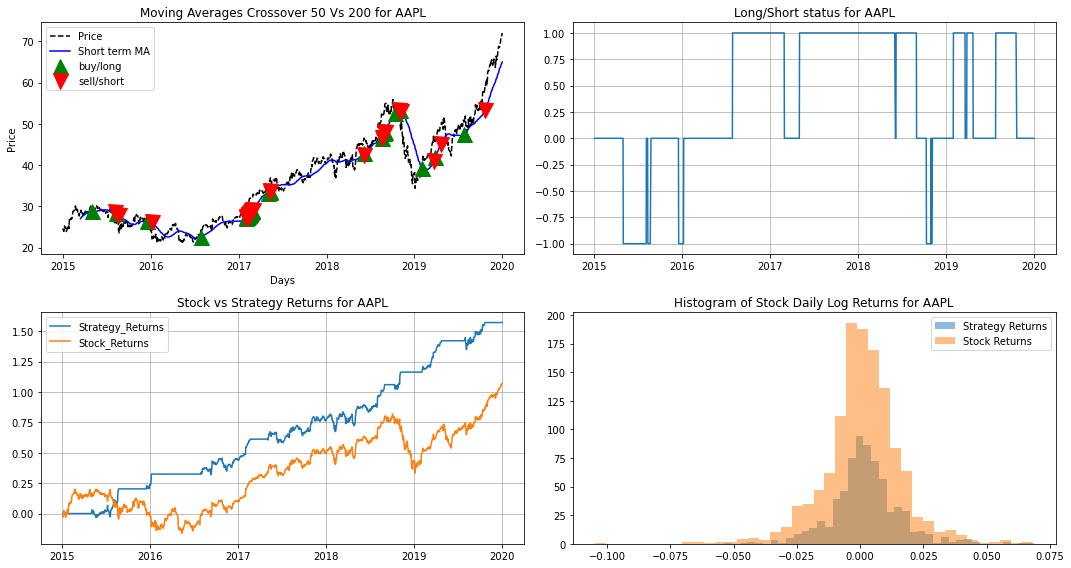

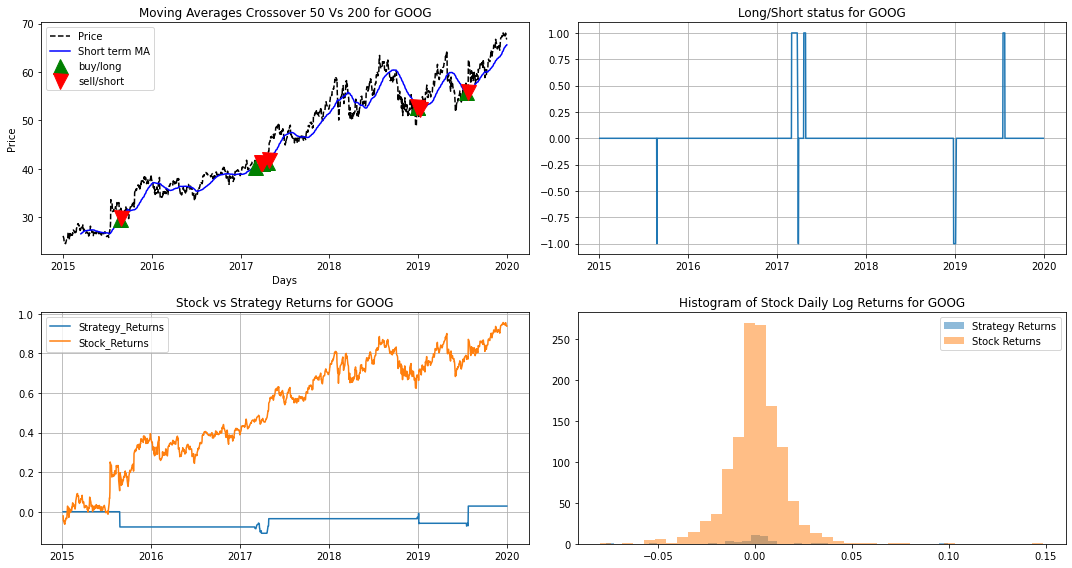

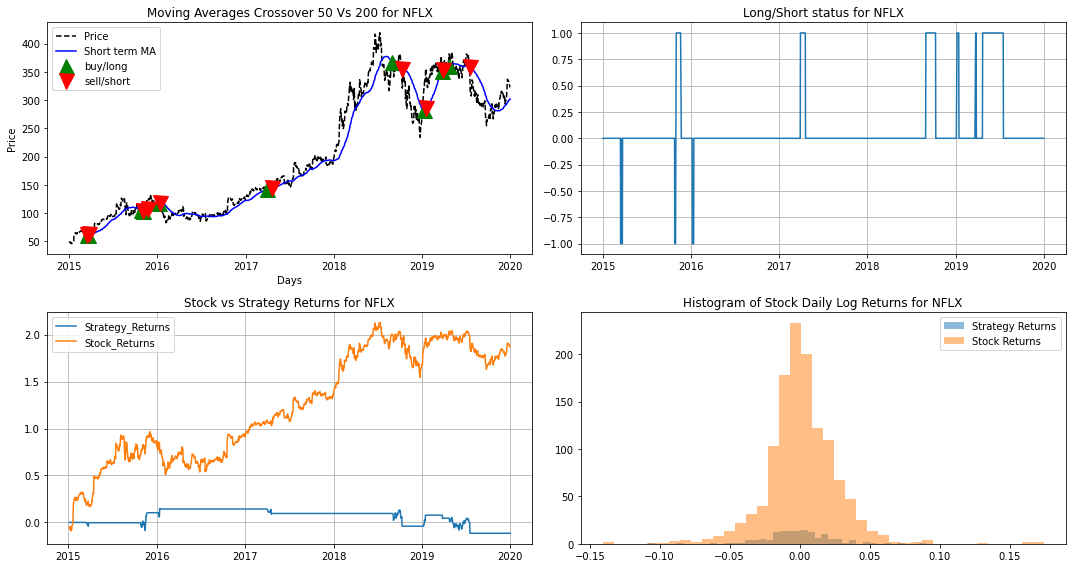

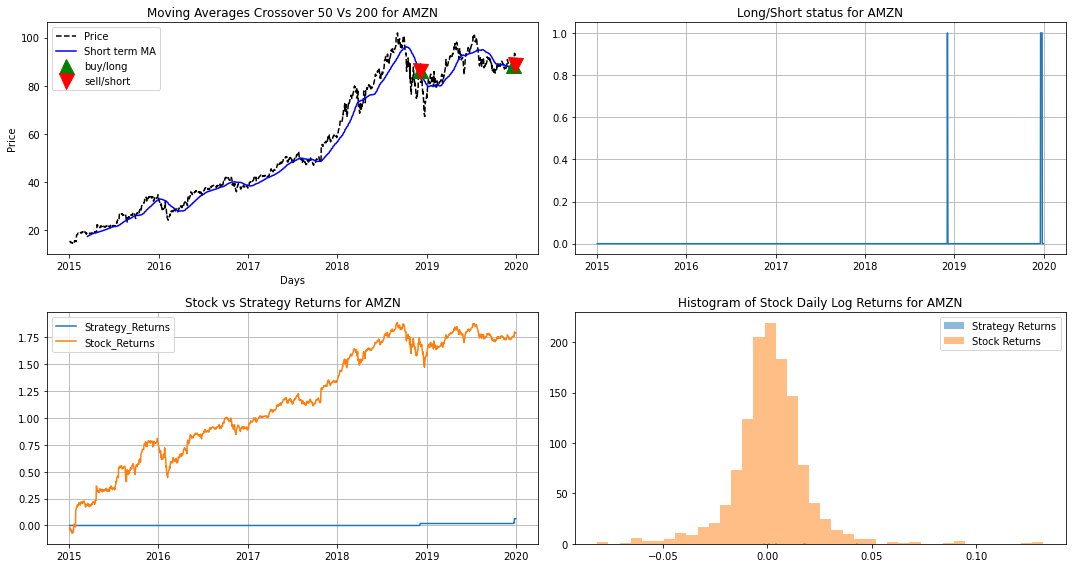

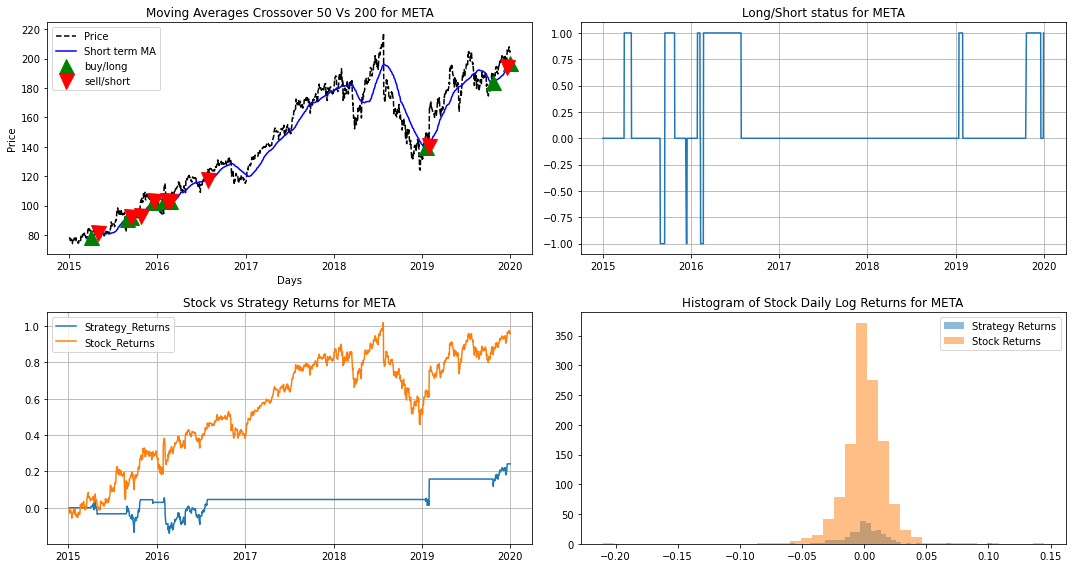

In [37]:
# strategy for multiple stocks, assuming capital allocation for each stock is equal
A = MA_Strategy(symbol = tickers,
                benchmark = benchmark_stock_symbol,
                start = start,
                end = end,
                interval = "1d",
                capital = 40000,
                transcation_cost = 0.01,
                primary_trend_window = primary_trend_window,
                buy_on = buy_on,
                long_sl_ATR_multiple = long_sl_ATR_multiple,
                risk_reward_long = risk_reward_long,
                close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                long_rsi_limit= long_rsi_limit,
                short_sl_ATR_multiple=short_sl_ATR_multiple,
                risk_reward_short=risk_reward_short,
                close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                short_rsi_limit=short_rsi_limit,
                verbose=True,)
# Run strategy
A.run_strategy(50,200)

In [33]:
A.capital_per_day

,capital,Returns_AAPL,Returns_GOOG,Returns_NFLX,Returns_AMZN,Returns_META,Total_Stock_Returns,Total_Stock_Returns_cum_sum,capital_after_settlement,capital_regular_returns,capital_log_returns,capital_returns_log_cum_sum,Cum_Max,drawdown
0,39600.014464,0.016588,-0.006640,-0.008210,-0.003837,0.016389,0.002858,0.002858,38756.004218,-0.021313,-0.021544,-0.021544,-0.021544,0.000000e+00
1,38756.004218,0.011194,0.015599,0.010931,0.008620,0.019343,0.013137,0.015995,38368.455676,-0.010000,-0.010050,-0.031594,-0.021544,1.005004e-02
2,38368.455676,-0.007579,-0.002702,0.004927,-0.005078,0.022487,0.002411,0.018406,38299.414878,-0.001799,-0.001801,-0.033395,-0.021544,1.185107e-02
3,38299.414878,-0.012629,0.004238,0.007241,0.013968,0.012609,0.005086,0.023492,37917.199287,-0.009980,-0.010030,-0.043425,-0.021544,2.188088e-02
4,37917.199287,0.010351,-0.002770,-0.007735,-0.008970,0.007490,-0.000327,0.023165,36293.285954,-0.042828,-0.043772,-0.087197,-0.021544,6.565293e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,48647.402463,0.021816,0.025905,0.037444,0.021781,0.026700,0.026729,1.095574,52798.680646,0.085334,0.081888,0.287657,0.453483,1.658265e-01
1161,52798.680646,0.001644,0.001476,0.000848,0.010506,0.001235,0.003142,1.101397,58354.210360,0.105221,0.100045,0.387702,0.453483,6.578119e-02
1191,58354.210360,0.019132,0.009360,0.014717,0.006369,0.008441,0.011604,1.172017,59252.402245,0.015392,0.015275,0.402977,0.453483,5.050637e-02
1206,59252.402245,0.005918,-0.011719,-0.017720,-0.012328,-0.017891,-0.010748,1.210195,62321.888126,0.051804,0.050506,0.453483,0.453483,1.110223e-16


In [38]:
A.all_data['META'].to_clipboard()

In [39]:
A.portfolio_df.to_clipboard()

In [40]:
A.strengths_df.to_clipboard()

In [9]:
A.strengths_df

,AAPL,GOOG,NFLX,AMZN,META,Chosen
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,None
2015-01-05,NaN,NaN,NaN,NaN,NaN,None
2015-01-06,NaN,NaN,NaN,NaN,NaN,None
2015-01-07,NaN,NaN,NaN,NaN,NaN,None
2015-01-08,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...
2019-12-24,0.0,0.0,0.0,0.194304,0.000000,AMZN
2019-12-26,0.0,0.0,0.0,0.000000,0.000000,AMZN
2019-12-27,0.0,0.0,0.0,0.000000,0.000000,
